In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions.import_pop_served import *

### Import Data

In [2]:
# CIWQS
ciwqs_facilities = pd.read_csv('data/facilities_list/NPDES+WDR Facilities List_20240906.csv')
# drop duplicate WDIDs
ciwqs_facilities.drop_duplicates(subset='WDID', keep='first', inplace=True)

#CWNS
facilities = pd.read_csv('data/cwns/CA_2022CWNS_APR2024/FACILITIES.csv', encoding='latin1', low_memory=False)[['CWNS_ID', 'FACILITY_NAME']]
facility_permits = pd.read_csv('data/cwns/CA_2022CWNS_APR2024/FACILITY_PERMIT.csv', encoding='latin1', low_memory=False).drop(columns=['FACILITY_ID', 'STATE_CODE'])
pop_served_cwns = pd.concat([
    pd.read_csv('data/cwns/CA_2022CWNS_APR2024/POPULATION_WASTEWATER.csv', encoding='latin1', low_memory=False),
    pd.read_csv('data/cwns/CA_2022CWNS_APR2024/POPULATION_WASTEWATER_CONFIRMED.csv', encoding='latin1', low_memory=False),
    pd.read_csv('data/cwns/CA_2022CWNS_APR2024/POPULATION_DECENTRALIZED.csv', encoding='latin1', low_memory=False)
])

## WW Surveillance
pop_served_ww_surveillance = pd.read_csv('data/ww_surveillance/wastewatersurveillancecalifornia.csv', low_memory=False)[['epaid', 'population_served']].dropna().drop_duplicates(subset='epaid')

# SSO Questionnaire
questionnaire = pd.read_csv('data/sso/Questionnaire.txt', low_memory=False, delimiter='\t')[['Wdid','SSOq Population Served']]

### Merge Datasets

In [3]:
# import CWNS population data
print(f'{len(facilities)} CWNS facilities')
facilities = facilities.merge(facility_permits, on='CWNS_ID', how='left')
print(f'{len(facilities)} CWNS facilities after merging with facility_permits')
facilities = facilities[~facilities['FACILITY_NAME'].str.contains('stormwater', case=False)]
print(f'{len(facilities)} CWNS facilities after dropping stormwater in name')
patterns_to_remove = [r'WDR ', r'WDR-', r'WDR', r'Order WQ ', r'WDR Order No. ', r'Order No. ', r'Order ', r'NO. ', r'ORDER NO. ', r'NO.', r'ORDER ', r'DWQ- ', r'NO.·', r'. ']
replacements = {r'·': '-', r'\?': '-'}
facilities['PERMIT_NUMBER_cwns_clean'] = facilities['PERMIT_NUMBER'].astype(str).replace('|'.join(patterns_to_remove), '', regex=True)
for old, new in replacements.items():
    facilities['PERMIT_NUMBER_cwns_clean'] = facilities['PERMIT_NUMBER_cwns_clean'].str.replace(old, new, regex=True)
facilities = facilities[facilities['PERMIT_NUMBER'] != '2006-0003-DWQ']
print(f'{len(facilities)} CWNS facilities after dropping 2006-0003-DWQ PERMIT_NUMBER')

# POPULATION
cwns_facilities = facilities.merge(pop_served_cwns, on='CWNS_ID', how='left').dropna(subset=['PERMIT_NUMBER'])
cwns_facilities = cwns_facilities.groupby(['CWNS_ID', 'PERMIT_NUMBER_cwns_clean'], as_index=False).agg({'TOTAL_RES_POPULATION_2022': 'sum', **{col: 'first' for col in cwns_facilities.columns if col not in ['CWNS_ID', 'PERMIT_NUMBER_cwns_clean', 'TOTAL_RES_POPULATION_2022']}})
print(f'{len(cwns_facilities)} CWNS facilities after merging with pop served and cleaning')

print(f'{len(ciwqs_facilities)} CIWQS WDIDs with {len(ciwqs_facilities["WDID"].unique())} WDIDs')

# Merge on 'NPDES # CA#' and 'ORDER #'
ciwqs_facilities = ciwqs_facilities.merge(cwns_facilities[['PERMIT_NUMBER_cwns_clean', 'TOTAL_RES_POPULATION_2022']], left_on='NPDES # CA#', right_on='PERMIT_NUMBER_cwns_clean', how='left')
# Now add matches for 'ORDER #'
na_mask = ciwqs_facilities['TOTAL_RES_POPULATION_2022'].isna()
order_match_dict = cwns_facilities.set_index('PERMIT_NUMBER_cwns_clean')['TOTAL_RES_POPULATION_2022'].to_dict()
ciwqs_facilities.loc[na_mask, 'TOTAL_RES_POPULATION_2022'] = ciwqs_facilities.loc[na_mask, 'ORDER #'].map(order_match_dict)
print(f'{len(ciwqs_facilities)} CIWQS WDIDs after merge with cwns_facilities')

# WW Surveillance
pop_served_ww_surveillance.rename(columns={'epaid': 'PERMIT_NUMBER_ww_surveillance'}, inplace=True)
ciwqs_facilities = ciwqs_facilities.merge(pop_served_ww_surveillance, left_on='NPDES # CA#', right_on='PERMIT_NUMBER_ww_surveillance', how='left')
print(f'{len(ciwqs_facilities)} CIWQS WDIDs after merging with pop_served_ww_surveillance')


# SSO Questionnaire
ciwqs_facilities['WDID'] = ciwqs_facilities['WDID'].astype(str)
questionnaire['Wdid'] = questionnaire['Wdid'].astype(str)
ciwqs_facilities = ciwqs_facilities.merge(questionnaire, left_on='WDID', right_on='Wdid', how='left')

# Prioritize population data
population_source_prioritization = {'CWNS': 'TOTAL_RES_POPULATION_2022', 'SSO Questionnaire': 'SSOq Population Served', 'Wastewater Surveillance': 'population_served'}
ciwqs_facilities[['POPULATION_SERVED', 'POPULATION_SOURCE']] = np.nan, 'None'
for source, column in population_source_prioritization.items():
    mask = ciwqs_facilities['POPULATION_SERVED'].isna()
    ciwqs_facilities.loc[mask, 'POPULATION_SERVED'] = pd.to_numeric(ciwqs_facilities.loc[mask, column], errors='coerce')
    ciwqs_facilities.loc[mask & ciwqs_facilities['POPULATION_SERVED'].notna(), 'POPULATION_SOURCE'] = source
ciwqs_facilities['POPULATION_SERVED'] = ciwqs_facilities['POPULATION_SERVED'].astype('float64')


924 CWNS facilities
996 CWNS facilities after merging with facility_permits
923 CWNS facilities after dropping stormwater in name
833 CWNS facilities after dropping 2006-0003-DWQ PERMIT_NUMBER
545 CWNS facilities after merging with pop served and cleaning
937 CIWQS WDIDs with 937 WDIDs
989 CIWQS WDIDs after merge with cwns_facilities
989 CIWQS WDIDs after merging with pop_served_ww_surveillance


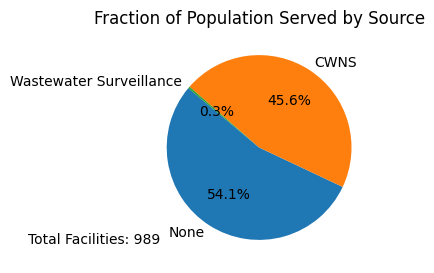

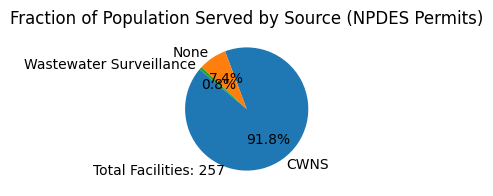

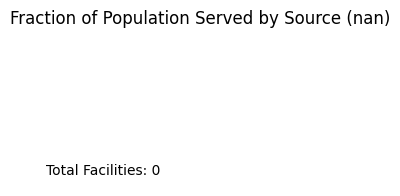

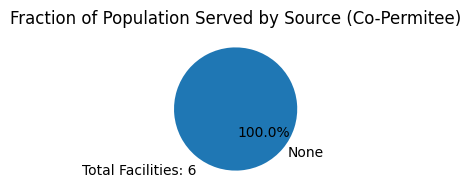

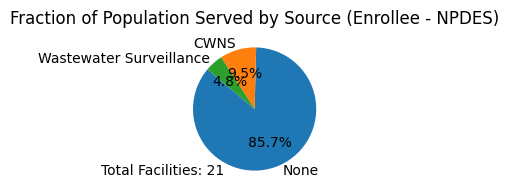

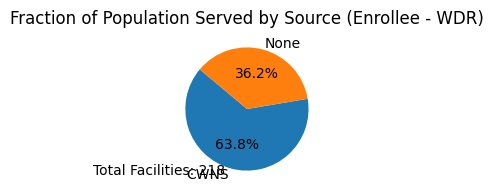

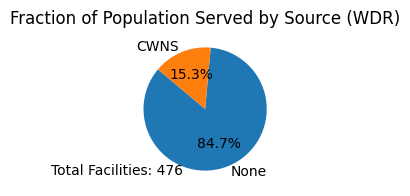

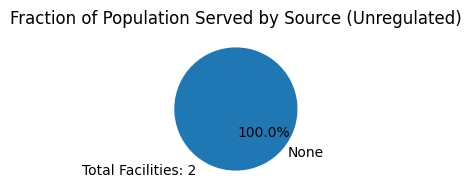

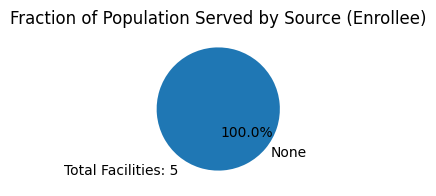

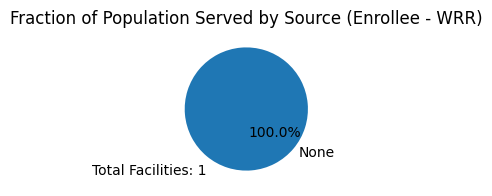

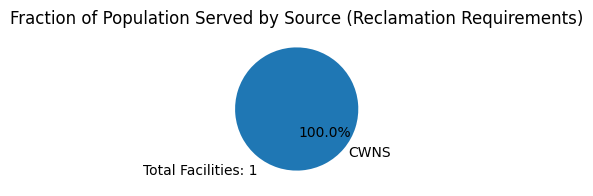

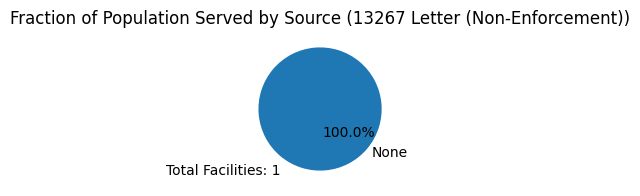

In [4]:
# Pie chart of fraction of population served by source
pop_counts = ciwqs_facilities['POPULATION_SOURCE'].value_counts()
plt.figure(figsize=(4, 3))
plt.pie(pop_counts, labels=pop_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Fraction of Population Served by Source')
# print total number of facilities in ciwqs_facilities on figure
plt.text(-0.5, 0.1, f'Total Facilities: {len(ciwqs_facilities)}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

# for each program category
for program_category in ciwqs_facilities['REG MEASURE TYPE'].unique():
    category_facilities = ciwqs_facilities[ciwqs_facilities['REG MEASURE TYPE'] == program_category]
    category_pop_counts = category_facilities['POPULATION_SOURCE'].value_counts()
    plt.figure(figsize=(3, 2))
    plt.pie(category_pop_counts, labels=category_pop_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Fraction of Population Served by Source ({program_category})')
    # print total number of facilities in category_facilities on figure
    plt.text(-0.5, 0.1, f'Total Facilities: {len(category_facilities)}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
    plt.show()